<a href="https://colab.research.google.com/github/JSEFERINO/JHSERIES2/blob/main/06_Series_Tiempo_Cap4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Curso Introductorio Series de Tiempo por Julio Hurtado Márquez**
## **Text: Time Series Forecasting in Python - MARCO PEIXEIRO**
# **Parte 2. Pronósticos con modelos estadísticos**

+ En esta parte del libro, exploraremos modelos estadísticos para el pronóstico de series de tiempo.
+ Al realizar modelos estadísticos, debemos realizar pruebas de hipótesis, estudiar nuestros datos detenidamente para extraer sus propiedades y encontrar el mejor modelo para nuestros datos.

+ Al final de esta parte, tendrá un marco sólido para modelar cualquier tipo de serie temporal utilizando modelos estadísticos.
+ Desarrollarás **modelos** $MA( q )$, **modelos** $AR( p )$, **modelos** $ARMA( p , q )$, **modelos** $ARIMA( p , d , q )$ para series temporales no estacionarias, $SARIMA( p , d , q )( P , D , Q )_m$ para **series temporales estacionales** y **modelos** $SARIMAX$ para incluir variables externas en su pronóstico.
+ También cubriremos el **modelo** $VAR(p)$ para predecir muchas series de tiempo a la vez.
+ Concluiremos esta parte del libro con un proyecto final, para que puedas aplicar lo que has aprendido por tu cuenta.

+ Por supuesto, existen muchos otros modelos estadísticos para el pronóstico de series temporales.
+ Por ejemplo, **el suavizado exponencial** básicamente toma un promedio ponderado de valores pasados ​​para predecir valores futuros.
+ La idea general detrás del suavizamiento exponencial es que los valores pasados ​​son menos importantes que los valores más recientes al predecir el futuro, por lo que se les asigna un peso menor.
+ Luego, este modelo puede ampliarse para incluir componentes de tendencia y estacionales.
+ También existen enfoques estadísticos para modelar series temporales con diferentes períodos estacionales, como los ***modelos BATS*** y ***TBATS***.

+ Para que esta sección sea manejable, no abordaremos esos modelos, pero están implementados en la *statsmodels*, que usaremos ampliamente.

# **Librerias del Capítulo 4**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.metrics

import statsmodels.tsa.stattools as sts # adf test
import statsmodels.graphics.tsaplots as sgt # plot acf
import statsmodels.tsa.statespace.sarimax as sarimax

# **4. Modelado de un proceso de media móvil**
## **Este capítulo cubre**
+ Definición de un proceso de media móvil
+ Uso del ACF para identificar el orden de un proceso de media móvil
+ Pronosticar una serie de tiempo utilizando el modelo de media móvil

## **Introducción**
+ En elEn el capítulo anterior, aprendió a identificar y pronosticar un proceso de paseo aleatorio.
+ Definimos un proceso de caminata aleatoria como una serie cuya primera diferencia es estacionaria sin autocorrelación.
+ *Esto significa que trazar su ACF no mostrará coeficientes significativos después del retraso 0*.
+ Sin embargo, es posible que un proceso estacionario aún pueda exhibir autocorrelación.
+ *En este caso, tenemos una serie de tiempo que puede aproximarse mediante un modelo de media móvil $MA( q )$, un modelo autorregresivo $AR( p )$, o un modelo de media móvil autorregresiva $ARMA( p , q)$*.
+ En este capítulo, nos centraremos en identificar y modelar utilizando el modelo de media móvil.

+ **Ejemplo**. *Suponga que desea pronosticar el volumen de ventas de widgets de XYZ Widget Company. Al predecir las ventas de futuros, la empresa podrá gestionar mejor su producción de widgets y evitar producir demasiados o muy pocos. Si no se producen suficientes widgets, la empresa no podrá satisfacer las demandas de sus clientes, lo que los dejará insatisfechos. Por otro lado, producir demasiados widgets aumentará el inventario. Los dispositivos podrían volverse obsoletos o perder su valor, lo que aumentará los pasivos de la empresa y, en última instancia, hará que los accionistas se sientan descontentos.*

+ *En esta situación, estudiaremos específicamente las ventas de widgets durante 500 días a partir de 2019. Podemos ver las ventas registradas a lo largo del tiempo en la Figura 4.1. Tenga en cuenta que el volumen de ventas se expresa en miles de dólares estadounidenses*.

+ **Figura 4.1 Volumen de ventas de widgets para XYZ Widget Company durante 500 días, a partir del 1 de enero de 2019. Estos son datos ficticios, pero serán útiles para aprender a identificar y modelar un proceso de promedio móvil.**

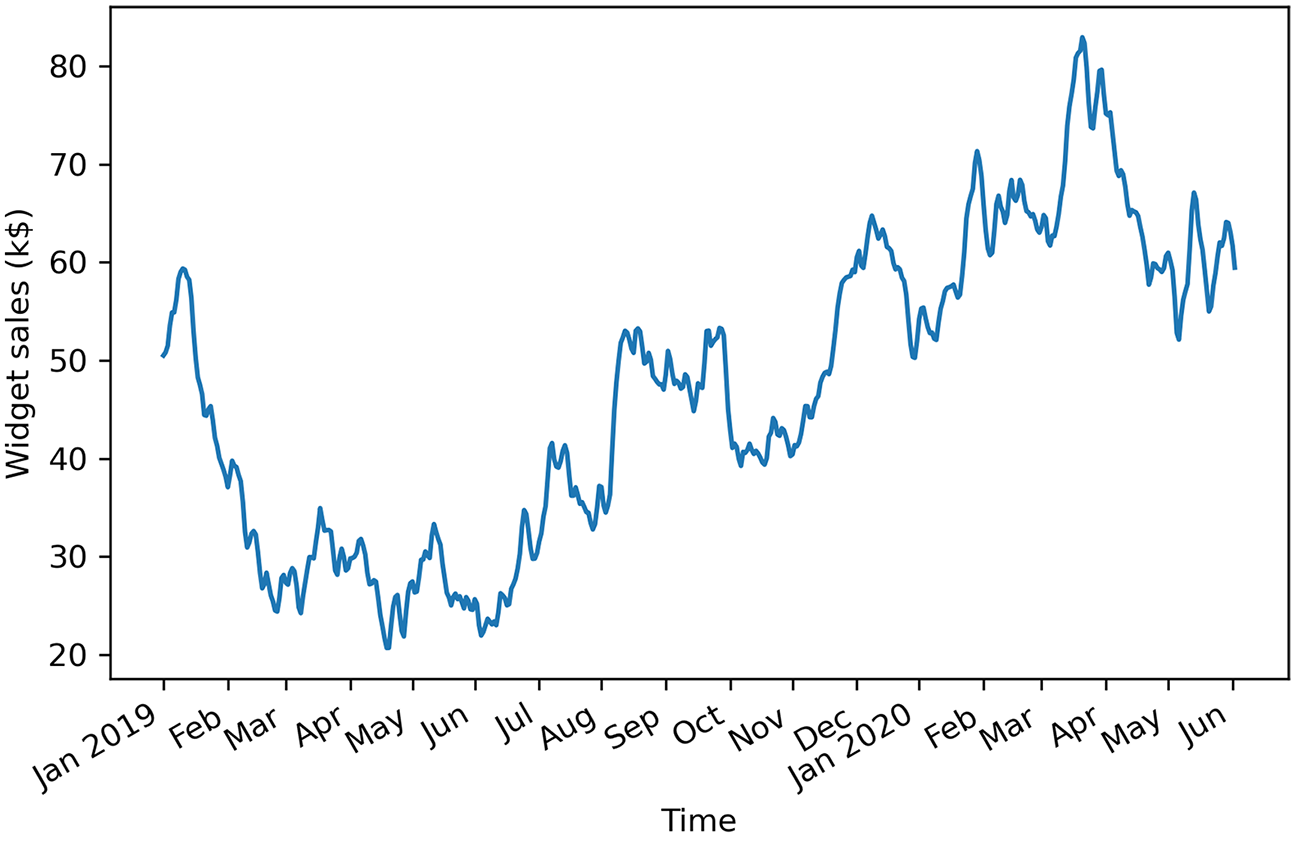

+ **Si observamos la figura 4.1, podemos ver una tendencia a largo plazo con picos y valles a lo largo del camino.**
+ *A partir de esta observación, podemos decir intuitivamente que esta serie de tiempo no es un proceso estacionario ya que observamos una tendencia a lo largo del tiempo.*
+ Además, *no hay ningún patrón cíclico aparente en los datos, por lo que podemos descartar cualquier efecto estacional por ahora.*

+ **Para pronosticar el volumen de ventas de widgets, necesitamos identificar el proceso subyacente. Para hacerlo, aplicaremos los mismos pasos que cubrimos en el capítulo 3 cuando trabajemos con un proceso de paseo aleatorio, como se muestra en la figura 4.2.**

+ Una vez recopilados los datos, realizaremos pruebas de estacionariedad.
+ En el caso de que no sea estacionario, aplicaremos una transformación para hacerlo estacionario.
+ Luego, una vez que la serie sea un proceso estacionario, trazaremos la función de autocorrelación, o ACF.
+ En este caso, resulta que nuestro proceso mostrará coeficientes significativos en el gráfico ACF, lo que significa que no puede ser aproximado mediante el modelo de paseo aleatorio.

+ ***Como cubriremos en este capítulo, descubriremos que el volumen de ventas de widgets de XYZ Widget Company se puede aproximar como un proceso de media móvil y aprenderemos la definición del modelo de media móvil. Luego, mostramos cómo identificar el orden del proceso de media móvil utilizando el gráfico ACF. El orden del proceso de media móvil determina el número de parámetros de nuestro modelo. Finalmente, aplicaremos el modelo de media móvil para pronosticar las ventas de widgets en los próximos 50 días.***

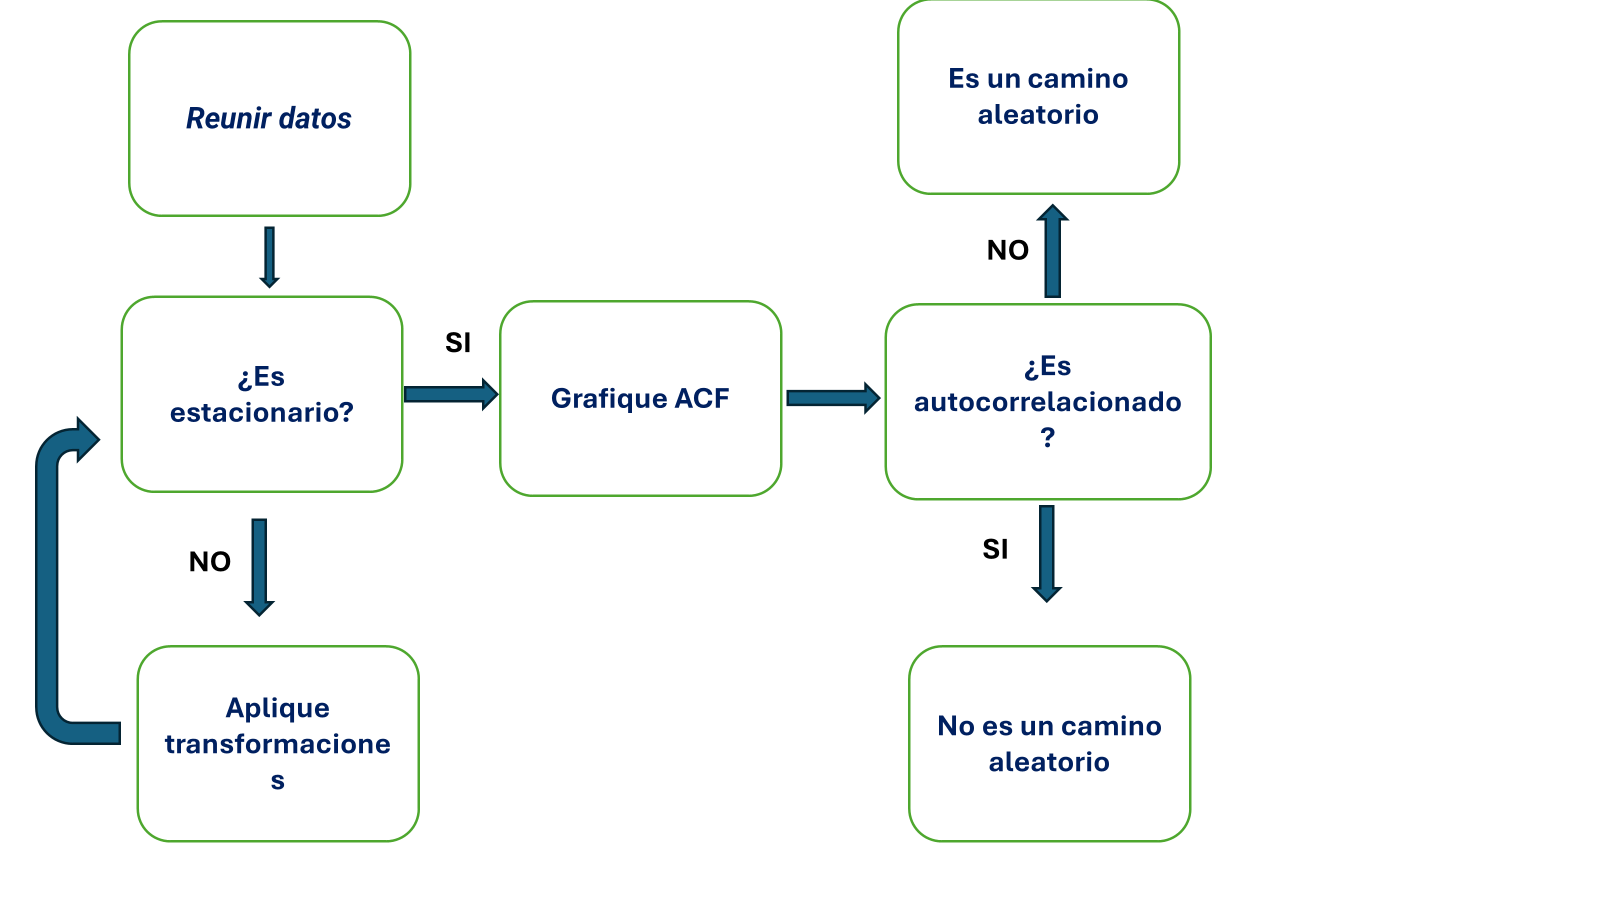

# **4.1. Definición de un proceso de media móvil - $MA$**
+ *Un proceso de media móvil, o modelo de media móvil, establece que el valor actual depende linealmente de los términos de error actuales y pasados. Nuevamente, se supone que los términos de error son mutuamente independientes y están distribuidos normalmente, como el ruido blanco.*

+ *Un modelo de media móvil se denota como MA(q) donde $q$ es el orden*.
+ El modelo expresa el valor presente como una combinación lineal de la media de la serie $μ$, el término de error presente $ϵ_t$ y los términos de error pasado $ϵ_{t-q}$ .
+ La magnitud del impacto de los errores pasados ​​en el valor presente se cuantifica utilizando un coeficiente denominado $θ_q$.
+ Matemáticamente, expresamos un proceso de orden de media móvil general como en la ecuación 4.1.

+ **Ecuación 4.1**
$$y_t = μ + ϵ_t + θ_1* ϵ_{t-1} + θ_2*ϵ_{t-2} + ⋅⋅⋅ + θ_q*ϵ_{t-q}$$


+ El orden $q$ del modelo de media móvil determina el número de términos de error pasados ​​que afectan el valor presente.
## **Proceso MA(1)**
+ **Por ejemplo, si es de orden uno, lo que significa que tenemos un proceso $MA(1)$, entonces el modelo se expresa como la ecuación 4.2. Aquí, vemos cómo el valor actual $y_t$ depende de la media $μ$ , el término de error actual $ϵ_t$ y el término de error en el paso de tiempo anterior $θ_ 1* ϵ_{t-1}$** .

+ **Ecuación 4.2**

$$y_t = μ + ϵ_t + θ_1* ϵ_{t-1} $$


## **Proceso MA(2)**
+ **Si tenemos un proceso de media móvil de orden dos, o MA(2), entonces $y-t$ depende de la media de la serie $μ$ , el término de error actual $ϵ_t$ , el término de error en el paso de tiempo anterior $θ_1*ϵ{t-1}$ y el término de error dos pasos de tiempo antes $θ_2*ϵ_{t-2}$, lo que da como resultado la ecuación 4.3.**

+ **Ecuación 4.3**
$$y_t = μ + ϵ_t + θ_1* ϵ_{t-1} + θ_2*ϵ_{t-2}$$

+ Por tanto, podemos ver cómo el orden $q$ del proceso $MA(q)$ afecta el número de términos de error pasados ​​que deben incluirse en el modelo.
+ Cuanto mayor es $q$ , más afectan los términos de error pasados ​​al valor presente.
+ Por lo tanto, es importante determinar el orden del proceso de media móvil para ajustarse al modelo apropiado, lo que significa que si tenemos un proceso de media móvil de segundo orden, entonces se utilizará un modelo de media móvil de segundo orden para realizar predicciones.

## **4.1.1 Identificar el orden de un proceso de media móvil**
+ Para identificar el orden de un proceso de media móvil, ampliamos los pasos necesarios para identificar un paseo aleatorio, como se muestra en la figura 4.3.

+ **Figura 4.3 Pasos para identificar el orden de un proceso de media móvil**

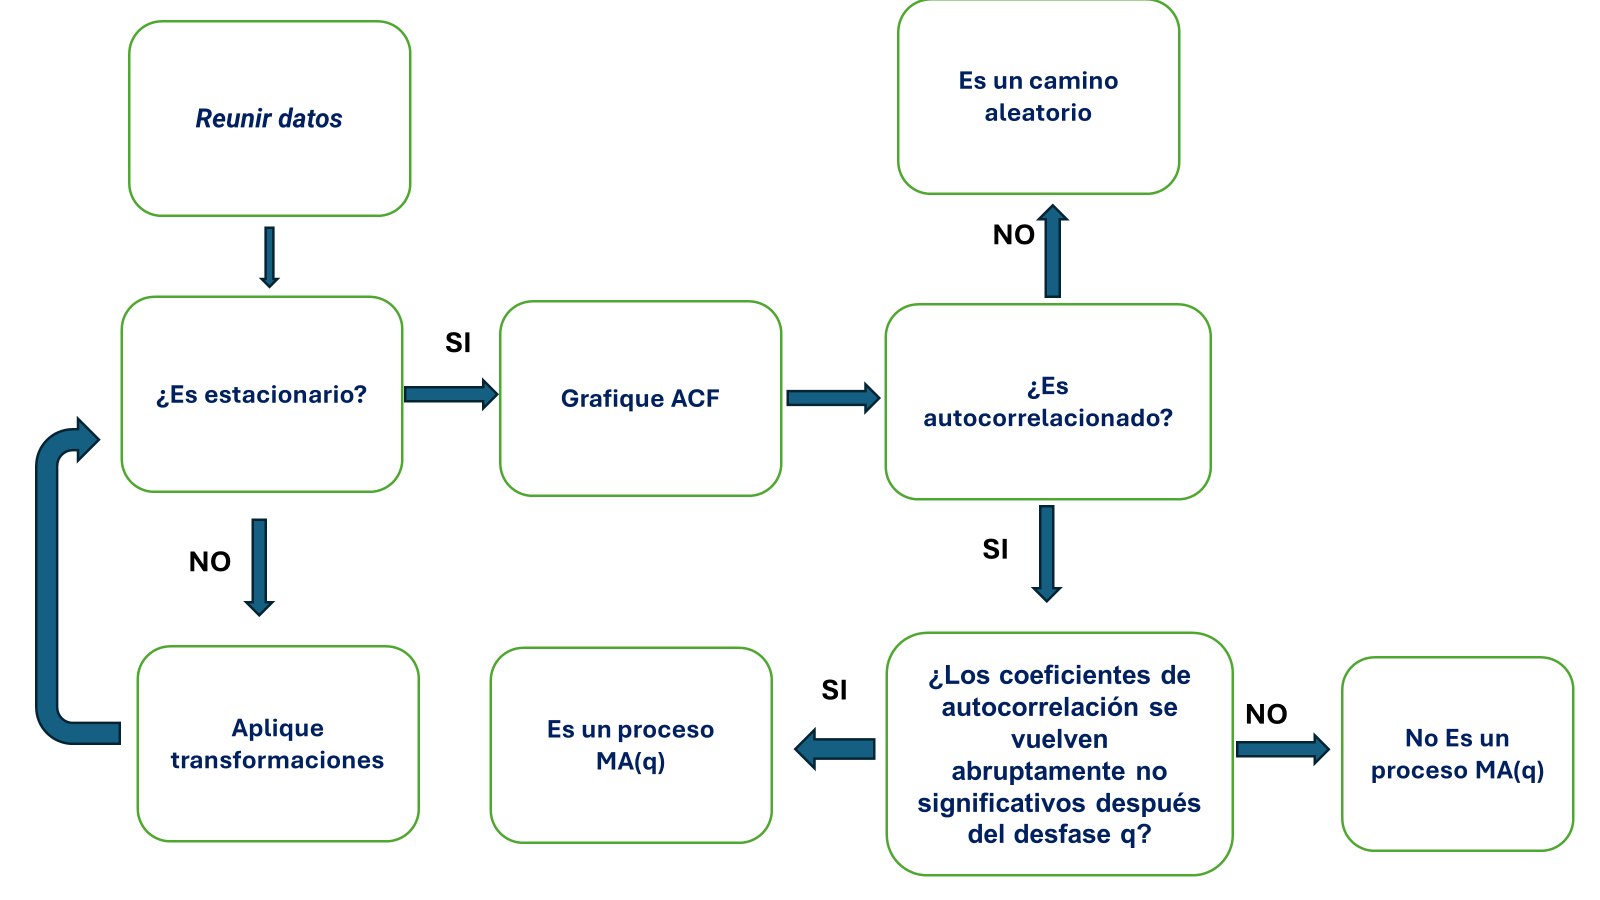

## **Ejemplo ilustrativo - Aplicar el proceso de promedio móvil al conjunto de datos de ventas**
+ *Pongamos esto en práctica utilizando nuestros datos para el volumen de ventas de widgets de XYZ Widget Company.*
+ *El conjunto de datos contiene 500 días de datos de volumen de ventas a partir del 1 de enero de 2019. Seguiremos el conjunto de pasos descritos en la figura 4.3 y determinaremos el orden del proceso de promedio móvil subyacente.*

+ *El primer paso es recopilar los datos. Si bien este paso ya se realizó por usted, este es un buen momento para cargar los datos en un DataFrame uso pandas y mostrar las primeras cinco filas de datos:*



In [ ]:
df = pd.read_csv('/content/widget_sales.csv')
# Sabemos de antemano que estas rebajas comienzan el 1 de enero.
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


+ Verás que nuestro volumen de ventas está en la columna widget_sales .
+ Tenga en cuenta que el volumen de ventas está en unidades de miles de dólares estadounidenses.

+ Podemos trazar nuestros datos usando matplotlib. Nuestros valores de interés están en las columnas widget_sales , así que eso es lo que pasamos a ax.plot().
+ Luego, le damos al eje x la etiqueta de Tiempo y al eje y la etiqueta de Ventas de widgets (k$) .
+ A continuación, especificamos la etiqueta de las marcas en el eje x para mostrar el mes del año. Finalmente, inclinamos las etiquetas x-ticks y eliminamos espacios en blanco adicionales alrededor de la figura usando plt.tight_layout().
+ **El resultado es la figura 4.4.**

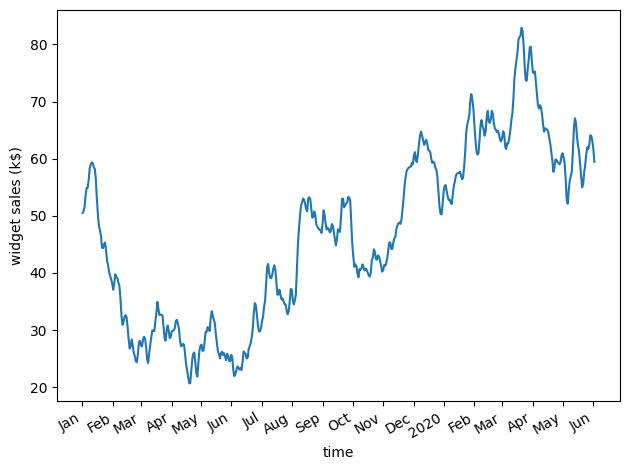

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.widget_sales)

ax.set_xlabel('time')
ax.set_ylabel('widget sales (k$)')

# no encontré una mejor manera de dividir mejor las líneas (regla de los 80 caracteres),
# lo siento muchachos
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293,
         323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
         'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020',
         'Feb', 'Mar', 'Apr', 'May', 'Jun']
)

fig.autofmt_xdate()
plt.tight_layout()

+ El siguiente paso es probar la estacionariedad.
+ Intuitivamente sabemos que la serie no es estacionaria ya que hay una tendencia observable como se ve en la figura 4.4.
+ Aun así, utilizaremos la prueba del ADF para asegurarnos.

### **Prueba de Estacionariedad**

+ Nuevamente, usamos la *adfuller función* de la *statsmodels biblioteca* y extraemos la estadística *ADF* y el *valor p*.
+ Si el estadístico **ADF es un número negativo grande** y el **valor p es menor que 0.05**, entonces **nuestra serie es estacionaria**. En caso contrario, debemos aplicar transformaciones.

In [ ]:
## **Prueba de estacionariedad - ADF para la serie original**
adf = sts.adfuller(df.widget_sales)
print(f'El estadistico ADF = {adf[0]}')
print(f'valor p = {adf[1]}')

El estadistico ADF = -1.5121662069359048
valor p = 0.5274845352272605


+ Esto da como resultado una estadística ADF de -1,51 y un valor p de 0,53.
+ Aquí, la estadística ADF no es un número negativo grande y el valor p es mayor que 0,05.
+ **Por tanto, nuestra serie temporal no es estacionaria y debemos aplicar transformaciones para volverla estacionaria.**

+ Para que nuestra serie sea estacionaria, intentaremos estabilizar la tendencia aplicando una diferenciación de primer orden.
+ Podemos hacerlo utilizando el **diff método** de la numpy biblioteca.
+ Recuerde que este método toma un parámetro $n$ que especifica el orden de diferenciación.
+ En este caso, por ser una diferenciación de primer orden, $n=1$.

## **Diferenciando la Serie original**

In [ ]:
## **Diferenciando la Serie original**
diff_widget_sales = np.diff(df['widget_sales'], n=1) #Aplique la diferenciación de primer orden a nuestros datos
#y almacene el resultado en widget_sales_diff.


+ Opcionalmente podemos trazar la serie diferenciada para ver si estabilizamos la tendencia. La figura 4.5 muestra las series diferenciadas. Podemos ver que el componente de tendencia a largo plazo de nuestra serie se eliminó con éxito, ya que los valores rondan 0 durante todo el período.

In [ ]:
## **Prueba de estacionariedad - ADF para la serie diferenciada**
diff_adf = sts.adfuller(diff_widget_sales)
print(f'El estadistico para la serie diferenciada ADF = {diff_adf[0]}')
print(f'para la serie diferenciada: valor p = {diff_adf[1]}')

El estadistico para la serie diferenciada ADF = -10.576657780341959
para la serie diferenciada: valor p = 7.076922818587193e-19


+ ***Esto da una estadística ADF de -10,6 y un valor p de 7x10 -19 . Por lo tanto, con un estadístico ADF negativo grande y un valor p mucho menor que 0,05, podemos decir que nuestra serie es estacionaria.***

+ Opcionalmente podemos trazar la serie diferenciada para ver si estabilizamos la tendencia.
+ La figura 4.5 muestra las series diferenciadas.
+ Podemos ver que el componente de tendencia a largo plazo de nuestra serie se eliminó con éxito, ya que los valores rondan 0 durante todo el período.

+ **Figura 4.5 Volumen diferenciado de ventas de widgets. El componente tendencial se ha estabilizado, ya que los valores rondan el 0 en toda nuestra muestra.**

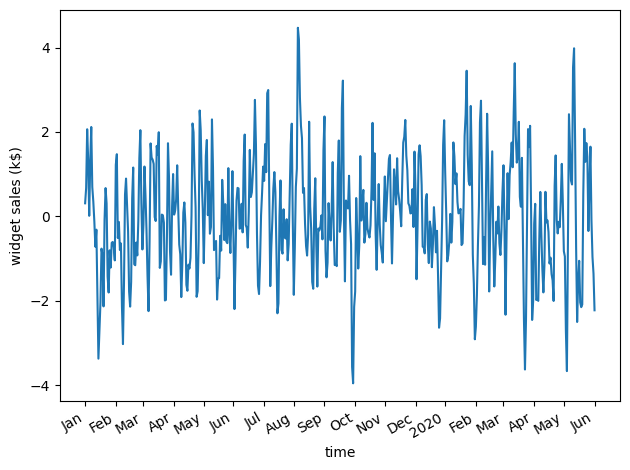

In [ ]:
fig, ax = plt.subplots()

ax.plot(diff_widget_sales)

ax.set_xlabel('time')
ax.set_ylabel('widget sales (k$)')

# no encontré una mejor manera de dividir mejor las líneas (regla de los 80 caracteres),
# lo siento muchachos
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293,
         323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
         'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020',
         'Feb', 'Mar', 'Apr', 'May', 'Jun']
)

fig.autofmt_xdate()
plt.tight_layout()

## **Trazar la función de autocorrelación - ACF**
+ Nuestro siguiente paso es trazar la función de autocorrelación.
+ La *statsmodels* biblioteca incluye cómodamente la *plot_acf* función para nosotros.
+ Simplemente pasamos nuestra serie diferenciada y especificamos el número de retrasos en el *lags* parámetro.
+ Recuerde que el número de retrasos determina el rango de valores en el eje x.

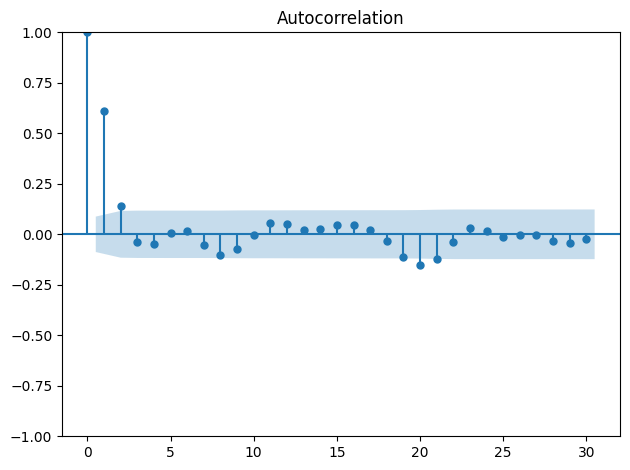

In [ ]:
## **Trazar la función de autocorrelación - ACF**
sgt.plot_acf(diff_widget_sales, lags = 30)
plt.tight_layout()

## **Análisis del gráfico de Autocorrelación**
+ **El gráfico ACF resultante se muestra en la figura 4.6.**
+ Observamos que hay coeficientes significativos después del retardo 0.
+ De hecho, son significativos hasta el retardo 2.
+ Luego, ***abruptamente se vuelven no significativos mientras permanecen en el área sombreada del gráfico.***
+ ***Podemos ver cierta significancia alrededor del retraso 20, pero probablemente se deba al azar, ya que los siguientes coeficientes no son significativos.***

+ **Figura 4.6 Gráfico ACF de la serie diferenciada. Observe cómo los coeficientes son significativos hasta el desfase 2 y luego caen abruptamente en la zona de no significancia (área sombreada) del gráfico. Hay algunos coeficientes significativos alrededor del rezago 20, pero esto probablemente se debe al azar, ya que no son significativos entre los rezagos 3 y 20 y después del rezago 20.**

# **4.2. Pronósticos de un proceso de media móvil**
+ Una vez que se identifica el orden $q$ del proceso de media móvil, podemos ajustar el modelo a nuestros datos de entrenamiento y comenzar a pronosticar.
+ En nuestro caso, descubrimos que el volumen diferenciado de ventas de widgets es un ***proceso de media móvil de orden 2, o un proceso MA(2)***.

+ El modelo de media móvil supone **estacionariedad**, lo que significa que nuestros pronósticos deben realizarse en una serie de tiempo estacionaria.
+ ***Por lo tanto, entrenaremos y probaremos nuestro modelo en el volumen diferenciado de ventas de widgets.***
+ Probaremos ***dos técnicas de pronóstico ingenuas*** y ajustaremos ***un modelo de media móvil de segundo orden***.
+ ***El pronóstico ingenuo servirá como línea base para evaluar el desempeño del modelo de promedio móvil, que esperamos que sea mejor que las líneas base ya que previamente identificamos nuestro proceso como un proceso de promedio móvil de orden 2.***
+ *Una vez que obtengamos nuestros pronósticos para el modelo estacionario. En el proceso, tendremos que desdiferenciar los pronósticos, lo que significa que debemos deshacer el proceso de diferenciación para que los pronósticos vuelvan a su escala original.*

+ Dividamos nuestros datos de inmediato.
+ Primero asignaremos los datos diferenciados a un archivo DataFrame.
+ Luego, el conjunto de entrenamiento será el primer 90% de los datos y el 10% restante será para el conjunto de prueba.
## **Modelo de promedio móvil de segundo orden - Serie diferenciada**
+ El modelo de promedio móvil de segundo orden recuerde que MA requiere que el conjunto de datos sea estacionario, por lo que necesitamos entrenar y probar contra el conjunto de datos diff, luego podemos transformarlo nuevamente.

In [ ]:
## **Modelo de promedio móvil de segundo orden - Serie diferenciada**
df_diff = pd.DataFrame({'widget_sales_diff': diff_widget_sales}) # Coloque los datos diferenciados en un DataFrame

In [ ]:
# Usaremos el 90% para entrenar y el 10% para probar
train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

In [ ]:
# para que podamos graficar el área gris y así sucesivamente
print(len(train))
print(len(test))

449
50


+ Hemos impreso el tamaño de los conjuntos de prueba y de entrenamiento para recordarle el punto de datos que perdemos cuando realizamos la diferenciación.
+ El conjunto de datos original contenía 500 puntos de datos, mientras que la serie diferenciada contiene un total de 499 puntos de datos, ya que realizamos la diferenciación una vez.
+ Ahora podemos visualizar el período de pronóstico para la serie diferenciada y la original.
+ Aquí crearemos dos subgráficos en la misma figura.
+ El resultado se muestra en la figura 4.7.

### **Graficas de la serie original y la serie diferenciada**

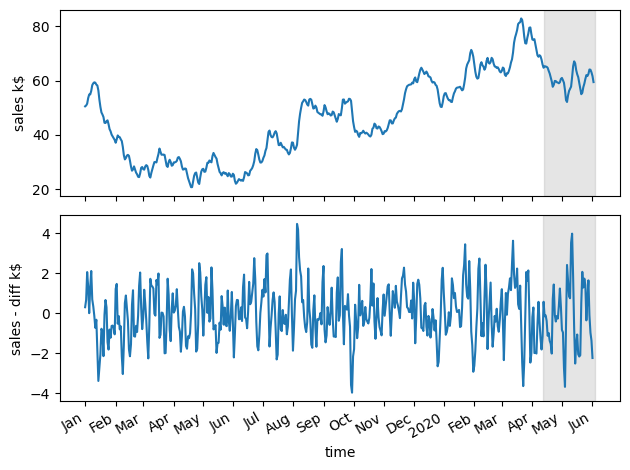

In [ ]:
### **Graficas de la serie original y la serie diferenciada**
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True)

ax1.plot(df.widget_sales)
ax1.set_ylabel('sales k$')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff.widget_sales_diff)
ax2.set_xlabel('time')
ax2.set_ylabel('sales - diff k$')
ax2.axvspan(len(train), 500, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409,
     439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
     'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])


fig.autofmt_xdate()
plt.tight_layout()

+ **Figura 4.7 Período de Pronóstico de la serie original y diferenciada. Recuerde que nuestra serie diferenciada tiene un dato menos que en su estado original.**

### **Acerca del horizonte de pronóstico con un $MA(q)$**
+ Para el horizonte de pronóstico, el modelo de promedio móvil presenta una particularidad. El modelo MA(q) no nos permite pronosticar 50 pasos hacia el futuro de una sola vez.
+ Recuerde que el modelo de promedio móvil depende linealmente de los términos de error pasados, y esos términos no se observan en el conjunto de datos; por lo tanto, deben estimarse de manera recursiva.
+ Esto significa que para un modelo MA(q), solo podemos pronosticar $q$ pasos hacia el futuro.
+ Cualquier predicción realizada más allá de ese punto no tendrá términos de error pasados, y el modelo solo predecirá la media.
+ Por lo tanto, no hay valor agregado en pronosticar más allá de $q$ pasos hacia el futuro, porque las predicciones no serán precisas, ya que solo se devuelve la media, que es equivalente a un modelo de referencia.
+ Para evitar simplemente predecir la media más allá de dos pasos de tiempo hacia el futuro, necesitamos desarrollar una función que prediga dos pasos de tiempo o menos a la vez, hasta que se realicen 50 predicciones, de modo que podamos comparar nuestras predicciones con los valores observados del conjunto de prueba.
+ Este método se llama ***pronósticos continuos***.
+ En la primera pasada, entrenaremos en los primeros 449 pasos de tiempo y predeciremos los pasos de tiempo 450 y 451.
+ Luego, en la segunda pasada, entrenaremos en los primeros 451 pasos de tiempo y predeciremos los pasos de tiempo 452 y 453.
+ Esto se repite hasta que finalmente predigamos los valores en los pasos de tiempo 498 y 499.

## **Pronosticando utilizando el modelo MA(q)**
+ Para evitar simplemente predecir la media más allá de dos pasos de tiempo en el futuro, necesitamos desarrollar una función que prediga dos pasos de tiempo o menos a la vez hasta que se hagan 50 predicciones, de modo que podamos comparar nuestras predicciones con los valores observados de la media en el Test
+ Este método se llama pronósticos móviles.
+ En el primer paso, entrenaremos en los 449 primeros pasos de tiempo y predeciremos los pasos de tiempo 450 y 451.
+ Luego, en el segundo pase, entrenaremos en los 451 primeros pasos de tiempo y predeciremos los pasos de tiempo 452 y 453.
+ Esto se repite hasta que finalmente prediquemos los valores en los pasos 498 y 499.

## **NOTA**
+ Compararemos nuestro modelo MA(2) ajustado con dos líneas de base: la media histórica y el último valor.
+ De esa manera, podemos asegurarnos de que un modelo MA(2) producirá mejores predicciones que los pronósticos ingenuos, lo que debería ser el caso ya que sabemos que el proceso estacionario es un proceso MA(2)


### **Función SARIMAX**
+ Tenga en cuenta que no es necesario pronosticar con 2 pasos de anticipación cuando realiza pronósticos continuos con un modelo $MA(2)$.
+ Puede realizar pronósticos de 1 paso adelante o de 2 pasos adelante repetidamente para evitar predecir solo la media.
+ De manera similar, con un modelo MA(3), podríamos realizar pronósticos continuos con pronósticos continuos de 1 paso, 2 pasos adelante o 3 pasos adelante.

+ Necesitamos una función que se ajuste repetidamente a un modelo y genere pronósticos durante un período de tiempo determinado, hasta que se obtengan pronósticos para todo el conjunto de pruebas.
+ Esta función se muestra en el listado 4.1.

+ Primero, importaremos la *SARIMAX función* de la *statsmodels biblioteca*.
+ **Esta función nos permitirá ajustar un modelo MA(2) a nuestra serie diferenciada.**
+ Tenga en cuenta que ***SARIMAX*** es un modelo complejo que nos permite considerar *efectos estacionales, procesos autorregresivos, series de tiempo no estacionarias, procesos de promedio móvil y variables exógenas, todo en un solo modelo*.
+ Por ahora, ignoraremos todos los factores excepto la parte de la media móvil.
+ Gradualmente nos basaremos en el modelo de media móvil para llegar finalmente al **modelo SARIMAX** en capítulos posteriores.

## **Describiendo el proceso**

+ Ahora, definimos nuestra **recursive_forecast** función.
+ Tomará en cuenta **DataFrame** la duración del conjunto de entrenamiento, el horizonte de pronóstico, el tamaño de la ventana y un método.

+ El DataFrame contiene la serie temporal completa.
+ El *train_len* parámetro inicializa el número de puntos de datos que se pueden utilizar para ajustar un modelo.
+ A medida que se realizan predicciones, podemos actualizar esto para simular la observación de nuevos valores y usarlos para realizar la siguiente secuencia de pronósticos.
+ El *horizon* parámetro es igual a la longitud del conjunto de prueba y representa cuántos valores se deben predecir.
+ Luego, el *window* parámetro especifica cuántos pasos de tiempo se predicen a la vez.
+ En nuestro caso, debido a que tenemos un proceso $MA(2)$, la ventana será igual a 2.
+ Finalmente, el *method* parámetro especifica qué modelo usar.
+ La misma función nos permite generar pronósticos a partir de **métodos ingenuos** y del **modelo MA(2)**.
+ Tenga en cuenta el uso de sugerencias de tipo en la declaración de función para evitar pasar parámetros de un tipo inesperado, evitando así que nuestra función falle.

+ Luego, cada método de pronóstico se ejecuta en bucle.
+ El bucle comienza en *train_len* hasta que *total_lens* excluye, que es la suma de *train_len* y *horizon*, con pasos de window.
+ Este bucle genera una lista de 25 valores: pero cada pasada genera dos pronósticos, devolviendo así una lista de 50 pronósticos para todo el conjunto de pruebas.

## **Pronóstico continuo**
+ Como p = 2, solo tomaremos 2 errores pasados ​​para calcular cada valor.
+ No podemos tomar esto y calcular 50 pasos de tiempo en el futuro, porque no tenemos los 2 errores pasados ​​para los valores futuros.

+ Lo que podemos hacer se llama pronóstico continuo, que básicamente consiste en iterar el entrenamiento y, en función de los nuevos resultados, obtener valores más adelante en el futuro.

+ Digamos que tenemos 10 pasos y un q de 2. En la primera iteración podemos predecir hasta 12, en la segunda tomaremos los nuevos valores y entrenaremos con ellos para poder llegar hasta 14.

+ Pero antes de divertirnos, establezcamos algunas líneas de base para tener algo con qué comparar. Entonces, crearemos una función que pueda hacer todas estas cosas :). Y por crear me refiero a copiar del libro

**Listado 4.1 Una función para pronósticos continuos en un horizonte**

+ La función toma un DataFrame que contiene el proceso de promedio móvil simulado completo. También pasamos la longitud del conjunto de entrenamiento (800 en este caso) y el horizonte del pronóstico (200). El siguiente parámetro especifica cuántos pasos a la vez deseamos pronosticar (2). Finalmente, especificamos el método que se utilizará para realizar pronósticos.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,
 window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value

    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2)) #El modelo MA(q) es parte del modelo SARIMAX más complejo.
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:] # El método predicted_mean nos permite recuperar
            pred_MA.extend(oos_pred) # el valor real del pronóstico según lo define la biblioteca statsmodels.

        return pred_MA

+ Una vez que se haya definido, podemos usar nuestra función y pronosticar usando tres métodos: **la media histórica, el último valor y el modelo MA(2) ajustado.**
+ Primero, crearemos un DataFrame para almacenar nuestras predicciones y lo llamaremos *pred_df.*
+ Podemos copiar el conjunto de prueba para incluir los valores reales en pred_df, lo que facilitará la evaluación del rendimiento de nuestros modelos.
+ Luego, especificaremos algunas constantes.
+ En Python, es una buena práctica nombrar las constantes en mayúsculas.
+ TRAIN_LEN es simplemente la longitud de nuestro conjunto de entrenamiento, HORIZON es la longitud del conjunto de prueba, que es de 50 días, y WINDOW puede ser 1 o 2 porque estamos usando un modelo MA(2). En este caso, usaremos un valor de 2.
+ A continuación, usaremos nuestra función rolling_forecast para generar una lista de predicciones para cada método. Luego, cada lista de predicciones se almacena en su propia columna en pred_df.

In [ ]:
TRAIN_LEN = len(train) # 449
HORIZON = len(test) # 50
WINDOW = 2

In [ ]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW,
 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


In [ ]:
pred_df.tail(20)

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
479,1.803364,0.030878,3.983943,1.839613
480,-0.734794,0.030878,3.983943,0.305052
481,-2.504808,0.032971,-0.734794,-0.895170
482,-1.529000,0.032971,-0.734794,-0.265056
483,-1.055167,0.024483,-1.529000,-0.288781
484,-2.041930,0.024483,-1.529000,0.040554
485,-2.153506,0.017996,-2.041930,-1.442341
486,-2.090140,0.017996,-2.041930,-0.370186
487,0.519777,0.009209,-2.090140,-1.153834
488,2.075603,0.009209,-2.090140,-0.291015


+ **Ahora graficaremos nuestros resultados e incluiremos parte del conjunto de entrenamiento.**

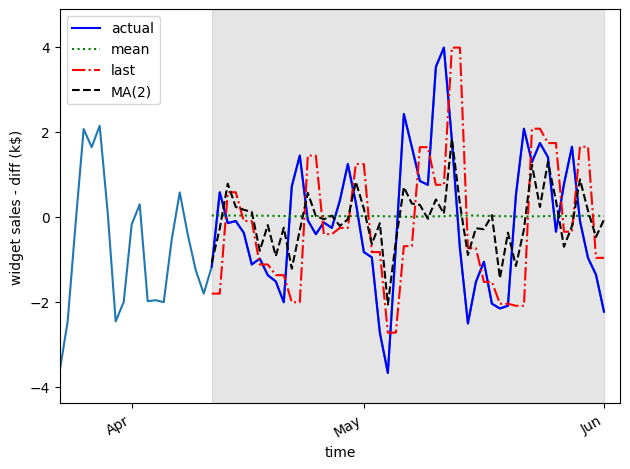

In [ ]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label = 'actual')
ax.plot(pred_df['pred_mean'], 'g:', label = 'mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label = 'last')
ax.plot(pred_df['pred_MA'], 'k--', label = 'MA(2)')

ax.legend(loc = 2)

ax.set_xlabel('time')
ax.set_ylabel('widget sales - diff (k$)')

ax.axvspan(449, 498, color = '#808080', alpha = 0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498],
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

### **Análisis gráficos**
+ Ahora podemos visualizar nuestras predicciones en relación con los valores observados en el conjunto de prueba.
+ Tenga en cuenta que todavía estamos trabajando con el conjunto de datos diferenciados, por lo que nuestras predicciones también son valores diferenciados.
+ Para esta figura, trazaremos parte de los datos de entrenamiento para ver la transición entre los conjuntos de entrenamiento y de prueba.
+ Nuestros valores observados serán una línea continua y etiquetaremos esta curva como "real".
+ Luego, trazaremos los pronósticos de la *media histórica*, *los del último valor observado* y los del *modelo MA(2)*.
+ Serán respectivamente una línea de puntos, una línea de puntos y discontinua, y una línea discontinua, con las etiquetas "media", "última" y "MA(2)".
+ El resultado se muestra en la figura 4.8.
+ **En la figura 4.8, notará que la predicción que proviene de la media histórica, que se muestra como una línea de puntos, es casi una línea recta.** Esto es lo esperado; el proceso es estacionario, por lo que la media histórica debería ser estable a lo largo del tiempo.
+ El siguiente paso es medir el rendimiento de nuestros modelos. + + Para ello, **calcularemos el error cuadrático medio (MSE)**.
+ Aquí utilizaremos la función *mean_squared_error* del paquete sklearn. Simplemente tenemos que pasar los valores observados y los valores predichos a la función.

##  **calcularemos el error cuadrático medio (MSE)**

In [ ]:
from sklearn.metrics import mean_squared_error
mse_mean = mean_squared_error(pred_df['widget_sales_diff'],
pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'],
pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'],
pred_df['pred_MA'])
print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.948171449776926


In [ ]:
print('El MSE  con los diferentes metodos ingenuos Y ma(2)')
print(f'El Error MSE con la media historica es {mse_mean}')
print(f'El Error MSE con la media con la última observación es {mse_last}')
print(f'El Error MSE con la MA(2) es {mse_MA}')

El MSE  con los diferentes metodos ingenuos Y ma(2)
El Error MSE con la media historica es 2.5606299456880537
El Error MSE con la media con la última observación es 3.2494260812249225
El Error MSE con la MA(2) es 1.948171449776926


###  **Graficando el error cuadrático medio (MSE)**

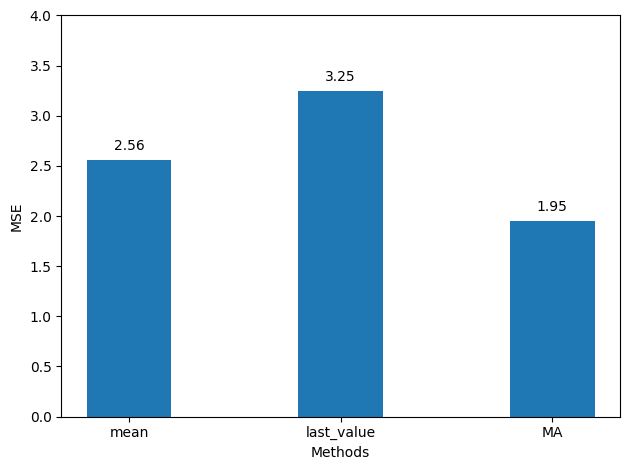

In [ ]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.savefig('figures', dpi=300)

+ **Figura 4.9 MSE para cada método de pronóstico sobre la diferencia en el volumen de ventas de artilugios. Aquí, el modelo MA(2) es el modelo campeón, ya que su MSE es el más bajo.**

### **Desdiferenciando la serie pronosticada**
+ Ahora que tenemos nuestro modelo campeón en la serie estacionaria, debemos *desdiferenciar* nuestras predicciones para devolverlas a la escala original del conjunto de datos no transformados.
+ Recuerde que la diferenciación es el resultado de la diferencia entre un valor en un momento y su valor anterior, como se muestra en la figura 4.10.
+ Para revertir nuestra diferencia de primer orden, necesitamos agregar un valor inicial $y_0$ al primer valor diferenciado $y'_1$ .
+ De esa forma, podemos recuperar $y_1$ en su escala original.
+ Esto es lo que se demuestra en la ecuación 4.4.
+ Entonces, $y_2$ se puede obtener usando una suma acumulativa de los valores diferenciados, como se muestra en la ecuación 4.5.
+ **Figura 4.10 Visualización de una diferencia de primer orden**

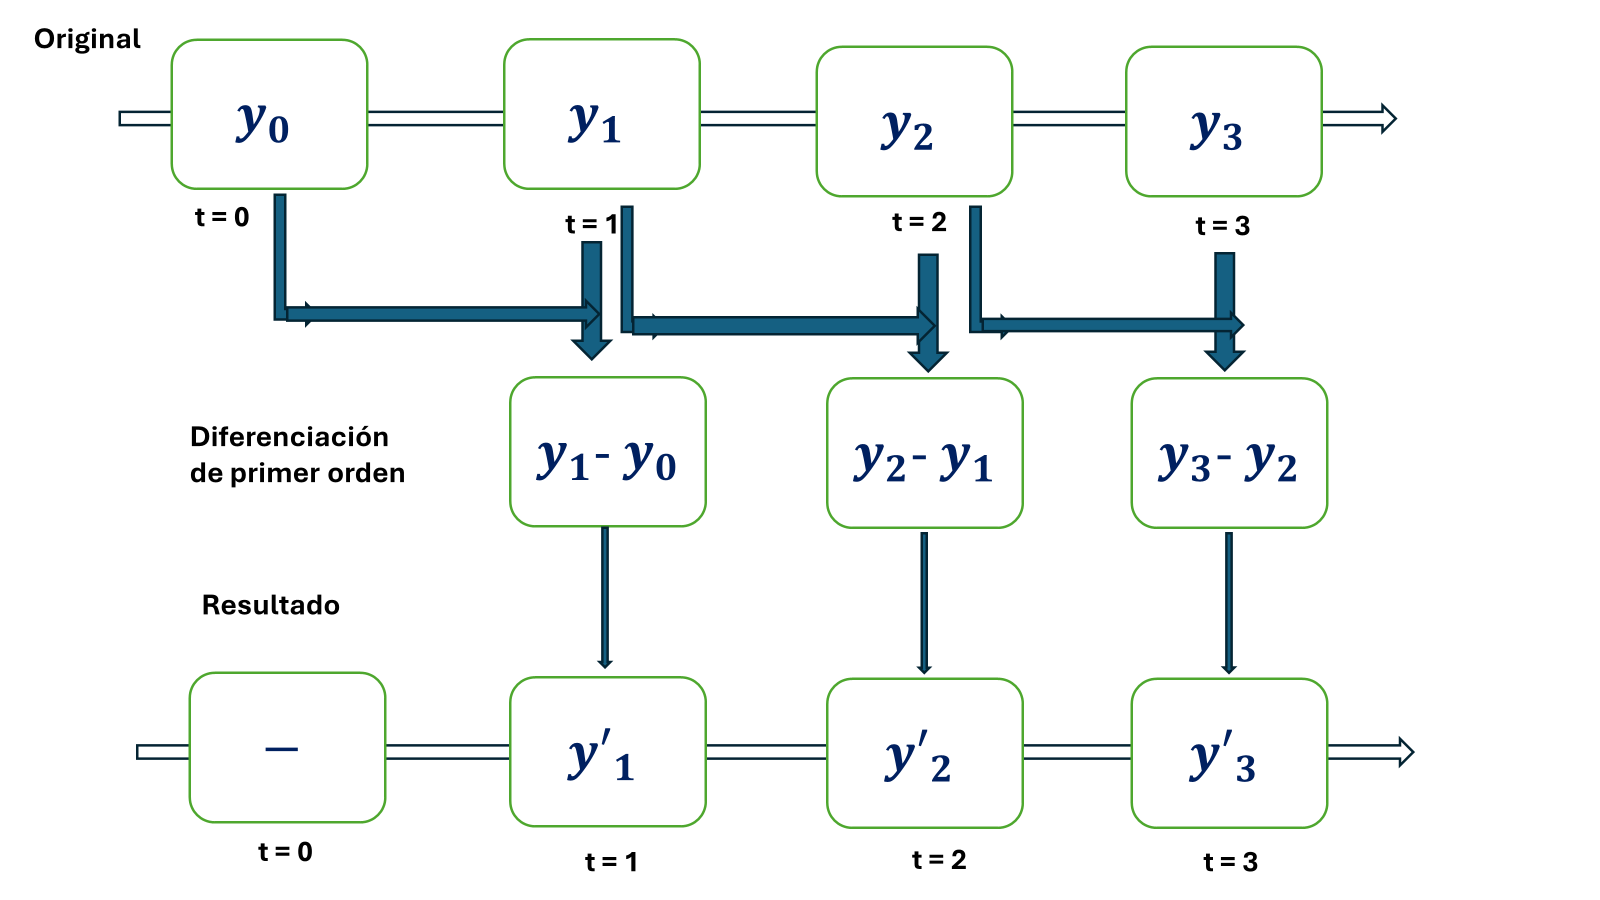

### **Desdiferenciando la serie pronosticada**
+ Por lo tanto, aplicar la suma acumulada una vez deshará la diferenciación de primer orden.
+ En el caso de que la serie se haya diferenciado dos veces para volverse estacionaria, entonces debemos repetir este proceso dos veces.

+ **Ecuación 4.4**
$$y_1 = y_0 + y'_1 = y_0 + y_1 - y_0 = y_1$$

+ **Ecuación 4.5**
$$y_2 = y_0 + y'_1 + y'_2 ​​= y_0 + (y_1 – y_0) + (y_2 – y_1) = y_2$$

+ Si aplicamos la suma acumulativa una vez, desharemos una diferenciación de primer orden.
+ En el caso de que la serie se haya diferenciado dos veces para volverse estacionaria, tendríamos que repetir este proceso.
+ Por lo tanto, para obtener nuestras predicciones en la escala original de nuestro conjunto de datos, necesitamos utilizar el primer valor de la prueba como nuestro valor inicial.
+ Luego podemos realizar una suma acumulativa para obtener una serie de 50 predicciones en la escala original del conjunto de datos. Asignaremos estas predicciones a la columna pred_widget_sales.

In [ ]:
df['pred_widget_sales'] = pd.Series() #Inicialice una columna vacía para almacenar nuestras predicciones.
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()
# Transforme inversamente las predicciones para devolverlas a la escala original del conjunto de datos.

<ipython-input-45-389f465b00da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()


+ **Visualicemos nuestras predicciones sin transformar en comparación con los datos registrados. Recuerde que ahora estamos utilizando el conjunto de datos original almacenado en df.**

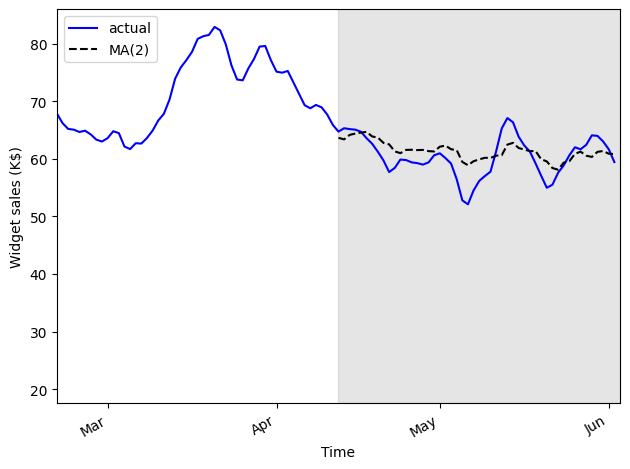

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')
ax.axvspan(450, 500, color='#808080', alpha=0.2)
ax.set_xlim(400, 500)

plt.xticks(
    [409, 439, 468, 498],
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

+ **Figura 4.11 Pronósticos MA(2) transformados inversamente**
+ Se puede ver en la figura 4.11 que nuestra curva de pronóstico, mostrada con una línea discontinua, sigue la tendencia general de los valores observados, aunque no predice valles y picos más grandes.

## **último paso es informar el MSE**
+ El último paso es informar el MSE en el conjunto de datos original.
+ En un entorno profesional, no reportaríamos las predicciones diferenciadas, porque no tienen sentido desde una perspectiva empresarial; debemos reportar valores y errores en la escala original de los datos.
+ Podemos medir el error absoluto medio (MAE) utilizando la función mean_absolute_error de sklearn.
+ Utilizaremos esta métrica porque es fácil de interpretar, ya que devuelve el promedio de la diferencia absoluta entre los valores predichos y los reales, en lugar de una diferencia al cuadrado como el MSE.

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:],
df['pred_widget_sales'].iloc[450:])
print(f'El Error MSE con la MA(2) en la serie original es {mae_MA_undiff}')

El Error MSE con la MA(2) en la serie original es 2.3244709244596082


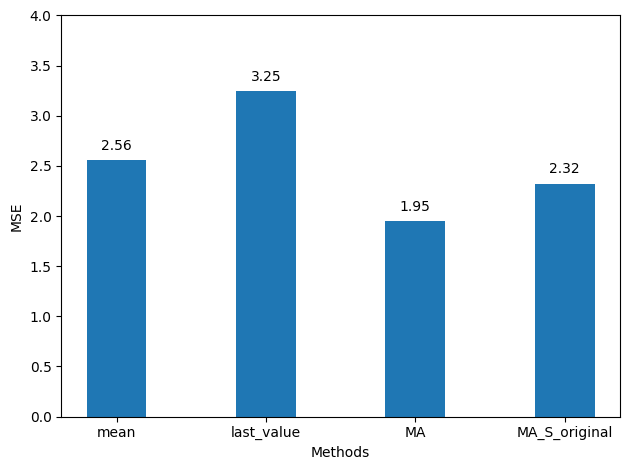

In [ ]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA', 'MA_S_original']
y = [mse_mean, mse_last, mse_MA,mae_MA_undiff ]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.savefig('figures', dpi=300)

## **Colores diferentes**

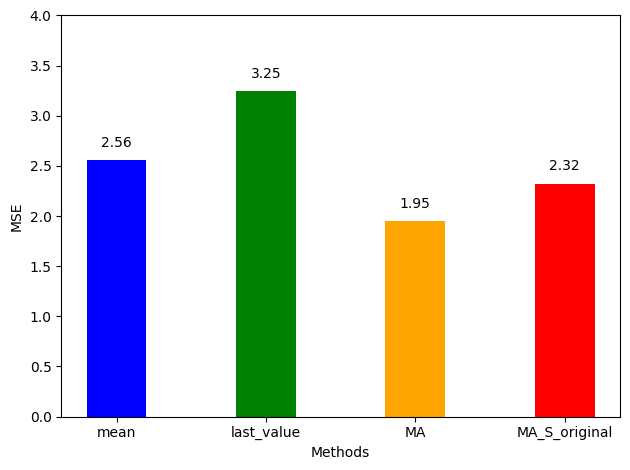

In [ ]:
import matplotlib.pyplot as plt

# Datos
x = ['mean', 'last_value', 'MA', 'MA_S_original']
y = [mse_mean, mse_last, mse_MA, mae_MA_undiff]

# Colores para las barras (puedes modificar esta lista según tus preferencias)
colors = ['blue', 'green', 'orange', 'red']

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Graficar las barras con colores específicos
bars = ax.bar(x, y, width=0.4, color=colors)

# Etiquetas y límites del eje y
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 4)

# Añadir texto con los valores encima de cada barra
for bar, value in zip(bars, y):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.1,
             round(value, 2),
             ha='center', va='bottom')

# Ajustar el diseño y guardar la figura
plt.tight_layout()
plt.savefig('figures.png', dpi=300)
plt.show()


# **4.3. Próximos pasos**
+ En este capítulo, cubrimos el proceso de media móvil y cómo se puede modelar mediante un modelo $MA(q)$ donde $q$ es el orden.
+ Aprendimos que para identificar un proceso de media móvil, debemos estudiar el gráfico ACF una vez que esté estacionario.
+ Luego, el gráfico ACF mostrará picos significativos hasta el retraso $q$ , y el resto no será significativamente diferente de 0.
+ Sin embargo, es posible que al estudiar el gráfico de ACF de un proceso estacionario, se observe un patrón sinusoidal, con coeficientes negativos y una autocorrelación significativa en grandes rezagos.

+ Por ahora, se puede simplemente aceptar que no se trata de un proceso de promedio móvil (véase la figura 4.12).

+ **Figura 4.12 Pasos para identificar el proceso subyacente de una serie temporal estacionaria**

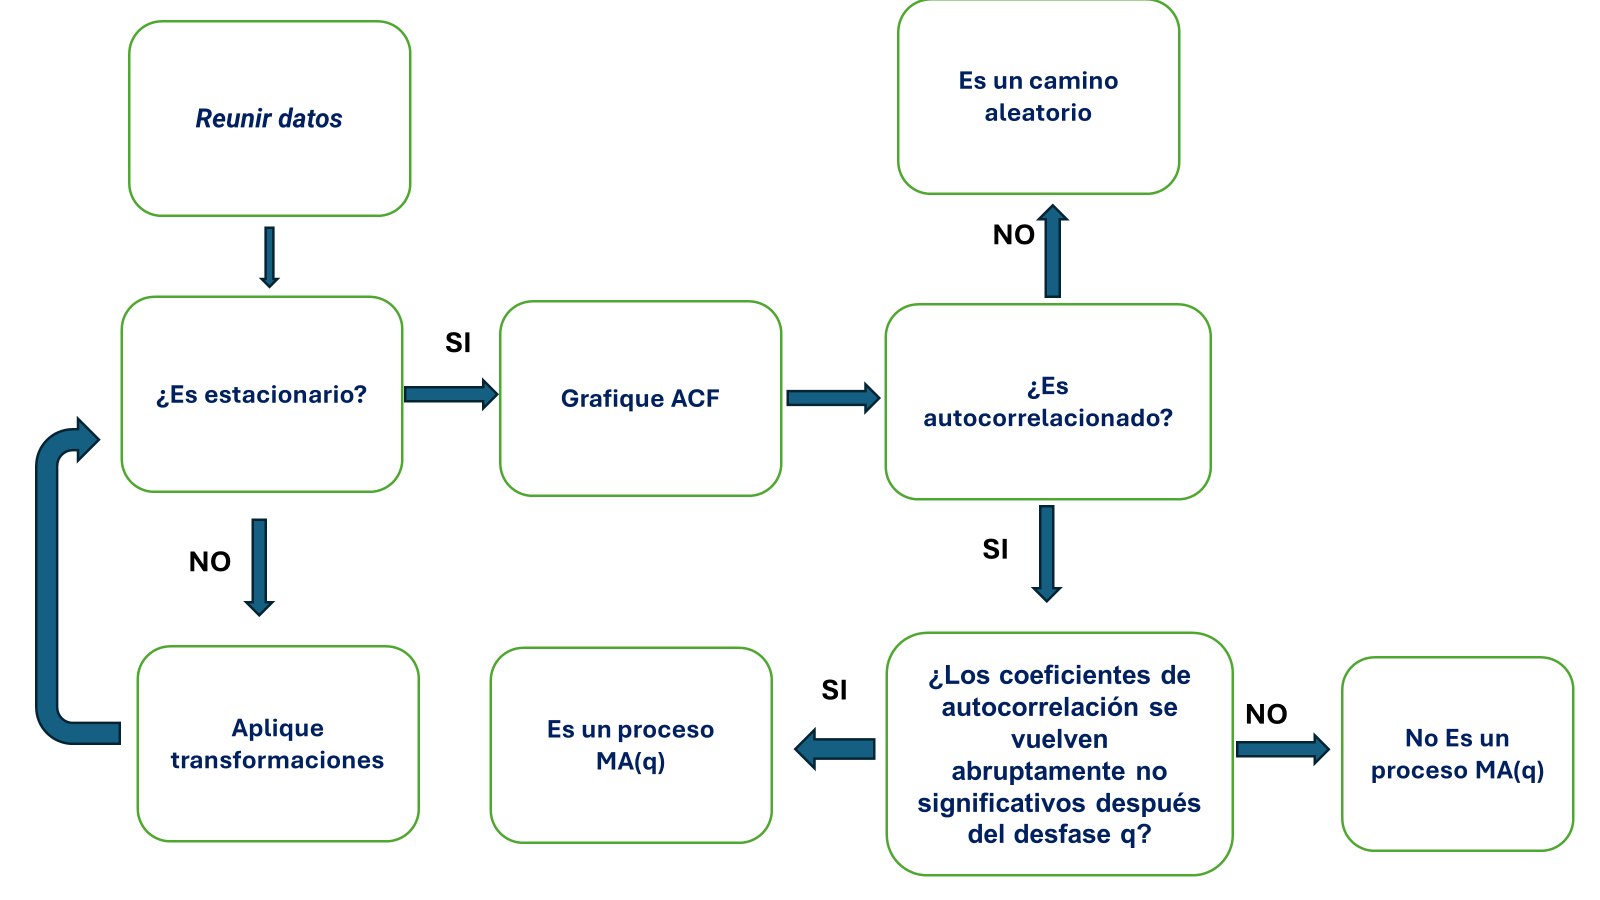

+ Cuando vemos un patrón sinusoidal en el gráfico de la ACF de un proceso estacionario, esto es un indicio de que se está produciendo un proceso autorregresivo y debemos utilizar un modelo AR(p) para generar nuestro pronóstico.
+ Al igual que el modelo MA(q), el modelo AR(p) requerirá que identifiquemos su orden.
+ Esta vez tendremos que trazar la función de autocorrelación parcial y ver en qué rezago los coeficientes de repente dejan de ser significativos.
+ El próximo capítulo se centrará por completo en el proceso autorregresivo, en cómo identificar su orden y en cómo pronosticar dicho proceso.

# **4.4. Ejercicios**
+ **Realizar pronósticos sobre el conjunto de prueba. Utilice la media, el último valor y un modelo MA(2). Asegúrese de pronosticar repetidamente 2 pasos de tiempo a la vez utilizando la recursive_forecastfunción tal como se define.**
## **4.4.1. Simular un proceso MA(2) y realizar pronósticos**
+ **Trace el ACF y vea si hay o no coeficientes significativos después del retraso 2.**
$$y_t = 0,9* θ_{t –1} + 0,3* θ_{t –2}$$

+ **1. Para este ejercicio, genere 1000 muestras.**
+ **2. Dibuje su promedio móvil simulado.**
+ **3. Ejecute la prueba ADF y verifique si el proceso es estacionario.**
+ **4. Dibuje la ACF y vea si hay coeficientes significativos después del desfase 2.**
+ **5. Separe su serie simulada en conjuntos de prueba y de entrenamiento. Tome los primeros 800 pasos de tiempo para el conjunto de entrenamiento y asigne el resto al conjunto de prueba.**
+ **6. Haga pronósticos sobre el conjunto de prueba. Use la media, el último valor y un modelo MA(2). Asegúrese de pronosticar repetidamente 2 pasos de tiempo a la vez usando la función recursive_forecast que definimos.**
+ **7. Dibuje sus pronósticos.**
+ **8. Mida el MSE e identifique su modelo campeón.**
+ **9. Dibuje sus MSE en un gráfico de barras.**

In [ ]:
## **Librerias**
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## **Solución ejercicio 4.4.1**

+ **1. Para este ejercicio, genere 1000 muestras.**
$$y_t = 0,9* θ_{t –1} + 0,3* θ_{t –2}$$

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42) # Establezca la semilla para la reproducibilidad.
# Cambie la semilla si desea experimentar con diferentes valores.

ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

## **Acerca de los arreglos**
+ Estos dos arrays que mencionas (`ma2` y `ar2`) parecen estar relacionados con modelos de series temporales, específicamente con modelos autoregresivos de media móvil (ARMA o ARIMA).
+ **ma2 = np.array([1, 0.9, 0.3])**:
  + Este array `ma2` parece representar los coeficientes de un modelo de media móvil (MA).
  + En un modelo MA(p), los términos se definen como:

   $
   X_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_p \epsilon_{t-p}$

   + donde $\epsilon_t$ son los errores, $\mu$ es la media y $\theta_1, \theta_2, \dots, \theta_p$ son los coeficientes del modelo de media móvil.
   + En el caso específico de `ma2`, los coeficientes son $[1, 0.9, 0.3]$, lo cual indica un modelo de media móvil de orden 2 (MA(2)) con coeficientes $\theta_1 = 0.9$ y $\theta_2 = 0.3$.
   + El primer coeficiente siempre es 1 en modelos de media móvil estacionarios.

+ **ar2 = np.array([1, 0, 0])**:

   + Este array `ar2` parece representar los coeficientes de un modelo autoregresivo (AR).
   + En un modelo AR(q), los términos se definen como:

   $
   X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_q X_{t-q} + \epsilon_t$

    + donde $\phi_1, \phi_2, \dots, \phi_q$ son los coeficientes del modelo autoregresivo y
    + $\epsilon_t$ es el término de error en el tiempo $t$.
    + En el caso específico de `ar2`, los coeficientes son $[1, 0, 0]$, lo cual indica un modelo autoregresivo de orden 2 (AR(2)) con coeficientes $\phi_1 = 0$ y $\phi_2 = 0$.
    + El primer coeficiente siempre es 1 en modelos autoregresivos estacionarios.

+ Estos modelos (AR y MA) son fundamentales en el análisis de series temporales para modelar y predecir datos basados en sus patrones de comportamiento pasado.
+ La elección de los coeficientes $\theta$ para $MA$ y $\phi$ para $AR$ influye en cómo el modelo captura y predice las fluctuaciones y la estructura de autocorrelación en los datos observados.

In [ ]:
ar2

array([1, 0, 0])

+ **2. Dibuje su promedio móvil simulado.**

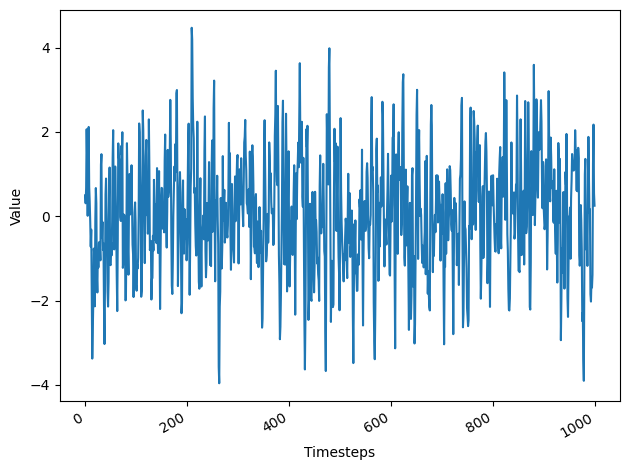

In [ ]:
fig, ax = plt.subplots()

ax.plot(MA2_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()

+ **3. Ejecute la prueba ADF y verifique si el proceso es estacionario.**

In [ ]:
ADF_result = adfuller(MA2_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -14.005444309194495
p-value: 3.7956016167135026e-26


+ Esto imprime una estadística ADF de -14 con un valor p de 0.
+ Aquí, la estadística ADF es un número negativo grande y el valor p es inferior a 0,05.
+ Por lo tanto, rechazamos la hipótesis nula y podemos decir que este proceso no tiene raíz unitaria y, por tanto, es estacionario.


+ **4. Dibuje la ACF y vea si hay coeficientes significativos después del desfase 2.**

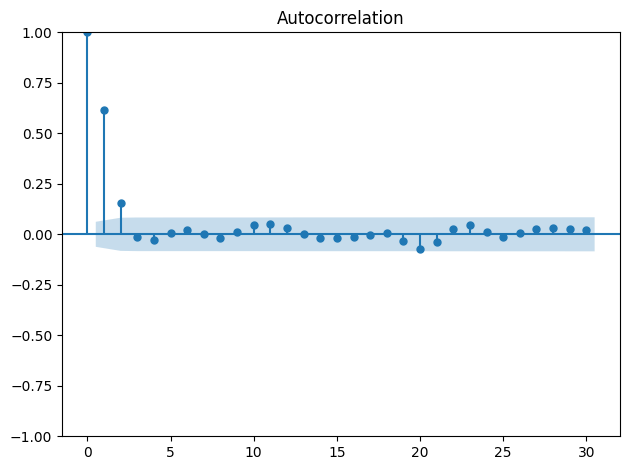

In [ ]:
plot_acf(MA2_process, lags=30);

plt.tight_layout()

+ **Gráfico ACF de la serie original. Observe cómo los coeficientes son significativos hasta el desfase 2 y luego caen abruptamente en la zona de no significancia (área sombreada) del gráfico.**


+ **5. Separe su serie simulada en conjuntos de prueba y de entrenamiento. Tome los primeros 800 pasos de tiempo para el conjunto de entrenamiento y asigne el resto al conjunto de prueba.**

In [ ]:
df = pd.DataFrame({'value': MA2_process})

train = df[:800]
test = df[800:]

In [ ]:

# Así que podemos graficar el área gris y así sucesivamente.
print(len(train))
print(len(test))

800
200


+ **6. Haga pronósticos sobre el conjunto de prueba. Use la media, el último valor y un modelo MA(2). Asegúrese de pronosticar repetidamente 2 pasos de tiempo a la vez usando la función recursive_forecast que definimos.**

In [ ]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)

        return pred_MA

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

In [ ]:
pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA2 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_MA2'] = pred_MA2

test.head()

,value,pred_mean,pred_last_value,pred_MA2
800,0.973560,-0.017430,0.259693,0.065366
801,0.337338,-0.017430,0.259693,0.017984
802,-0.086834,-0.015752,0.337338,-0.180397
803,-0.530580,-0.015752,0.337338,-0.116820
804,-0.821708,-0.016481,-0.530580,-0.405768


+ **7. Dibuje sus pronósticos.**

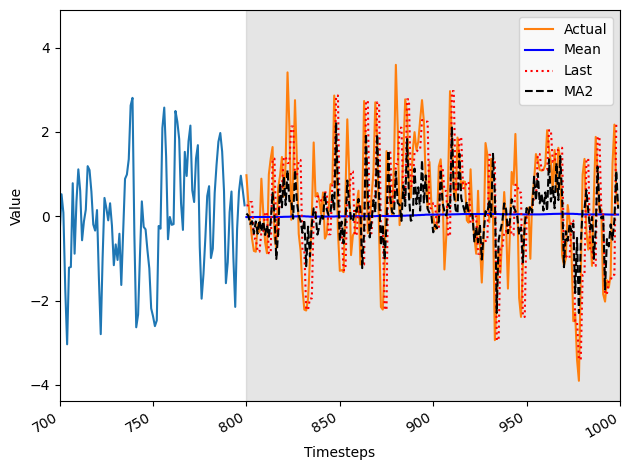

In [ ]:
fig, ax = plt.subplots()

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_mean'], 'b-', label='Mean')
ax.plot(test['pred_last_value'], 'r:', label='Last')
ax.plot(test['pred_MA2'], 'k--', label='MA2')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()


+ **8. Mida el MSE e identifique su modelo campeón.**

In [ ]:
from sklearn.metrics import mean_squared_error
mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_MA = mean_squared_error(test['value'], test['pred_MA2'])

print('El MSE  con los diferentes metodos ingenuos Y ma(2)')
print(f'El Error MSE con la media historica es {mse_mean}')
print(f'El Error MSE con la media con la última observación es {mse_last}')
print(f'El Error MSE con la MA(2) es {mse_MA}')

El MSE  con los diferentes metodos ingenuos Y ma(2)
El Error MSE con la media historica es 1.8635013982365882
El Error MSE con la media con la última observación es 1.988201688527919
El Error MSE con la MA(2) es 1.2323542190589272



+ **9. Dibuje sus MSE en un gráfico de barras.**

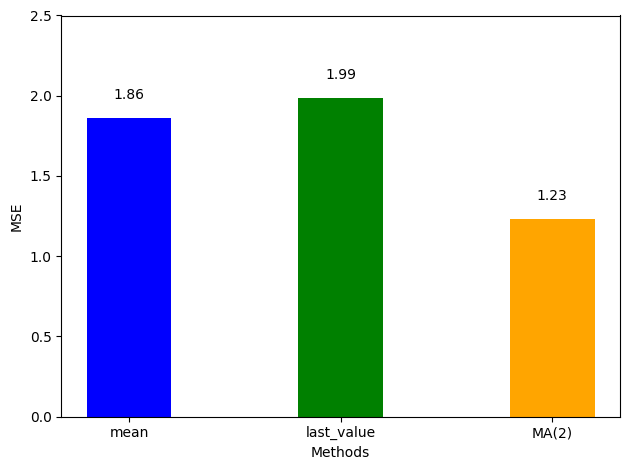

In [ ]:
import matplotlib.pyplot as plt

# Datos
x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

# Colores para las barras (puedes modificar esta lista según tus preferencias)
colors = ['blue', 'green', 'orange']

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Graficar las barras con colores específicos
bars = ax.bar(x, y, width=0.4, color=colors)

# Etiquetas y límites del eje y
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 2.5)

# Añadir texto con los valores encima de cada barra
for bar, value in zip(bars, y):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.1,
             round(value, 2),
             ha='center', va='bottom')

# Ajustar el diseño y guardar la figura
plt.tight_layout()
plt.savefig('figures.png', dpi=300)
plt.show()


# **Ejercicio 4.4.2. Simular un proceso MA(q) y realizar pronósticos**
+ Recrea el ejercicio anterior pero simula un proceso de media móvil de tu elección.
+ Intente simular un proceso de media móvil de tercer o cuarto orden.
+ En este caso, recomendaría generar 10.000 muestras. Esté especialmente atento al ACF y vea si sus coeficientes dejan de ser significativos después del retraso $q$.

+ **1. Para este ejercicio, genere 10000 muestras.**

In [ ]:
np.random.seed(42)

ma3 = np.array([1, 0.9, 0.3, 0.2])
ar3 = np.array([1, 0, 0, 0])

MA3_process = ArmaProcess(ar3, ma3).generate_sample(nsample=10000)

## **Acerca de los arreglos**
+ Estos dos arrays que mencionas (`ma2` y `ar2`) parecen estar relacionados con modelos de series temporales, específicamente con modelos autoregresivos de media móvil (ARMA o ARIMA).
+ **ma3 = np.array([1, 0.9, 0.3, 0.2])**:
  + Este array `ma2` parece representar los coeficientes de un modelo de media móvil (MA).
  + En un modelo MA(p), los términos se definen como:

   $
   X_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_p \epsilon_{t-p}$

   + donde $\epsilon_t$ son los errores, $\mu$ es la media y $\theta_1, \theta_2, \dots, \theta_p$ son los coeficientes del modelo de media móvil.
   + En el caso específico de `ma2`, los coeficientes son $[1, 0.9, 0.3, 02]$, lo cual indica un modelo de media móvil de orden 2 (MA(2)) con coeficientes $\theta_1 = 0.9$, \theta_2 = 0.3$ y $\theta_3 = 0.2$.
   + El primer coeficiente siempre es 1 en modelos de media móvil estacionarios.

+ **ar3 = np.array([1, 0, 0, 0])**:

   + Este array `ar2` parece representar los coeficientes de un modelo autoregresivo (AR).
   + En un modelo AR(q), los términos se definen como:

   $
   X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_q X_{t-q} + \epsilon_t$

    + donde $\phi_1, \phi_2, \dots, \phi_q$ son los coeficientes del modelo autoregresivo y
    + $\epsilon_t$ es el término de error en el tiempo $t$.
    + En el caso específico de `ar2`, los coeficientes son $[1, 0, 0]$, lo cual indica un modelo autoregresivo de orden 2 (AR(2)) con coeficientes $\phi_1 = 0$, $\phi_2 = 0$ y $\phi_3 = 0$.
    + El primer coeficiente siempre es 1 en modelos autoregresivos estacionarios.

+ Estos modelos (AR y MA) son fundamentales en el análisis de series temporales para modelar y predecir datos basados en sus patrones de comportamiento pasado.
+ La elección de los coeficientes $\theta$ para $MA$ y $\phi$ para $AR$ influye en cómo el modelo captura y predice las fluctuaciones y la estructura de autocorrelación en los datos observados.

+ **2. Dibuje su promedio móvil simulado.**

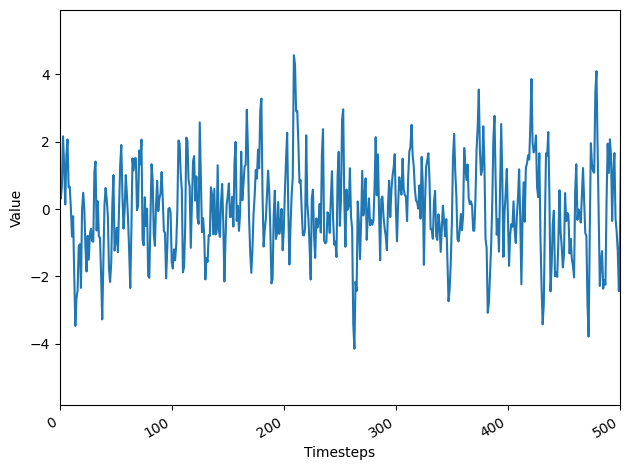

In [ ]:
fig, ax = plt.subplots()

ax.plot(MA3_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(0, 500)

fig.autofmt_xdate()
plt.tight_layout()

+ **3. Ejecute la prueba ADF y verifique si el proceso es estacionario.**

In [ ]:
ADF_result = adfuller(MA3_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -22.871933261080738
p-value: 0.0


+ Esto imprime una estadística ADF de -22.9 con un valor p de 0.
+ Aquí, la estadística ADF es un número negativo grande y el valor p es inferior a 0,05.
+ Por lo tanto, rechazamos la hipótesis nula y podemos decir que este proceso no tiene raíz unitaria y, por tanto, es estacionario.

+ **4. Dibuje la ACF y vea si hay coeficientes significativos después del desfase 2.**

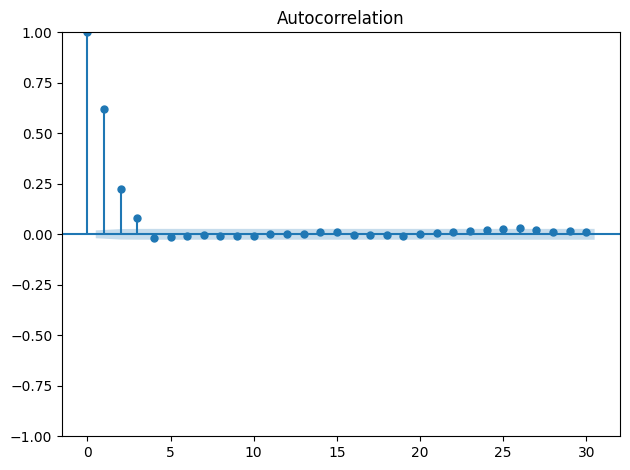

In [ ]:
plot_acf(MA3_process, lags=30);

plt.tight_layout()

+ **Gráfico ACF de la serie original. Observe cómo los coeficientes son significativos hasta el desfase 3 y luego caen abruptamente en la zona de no significancia (área sombreada) del gráfico.**

+ **5. Separe su serie simulada en conjuntos de prueba y de entrenamiento. Tome los primeros 800 pasos de tiempo para el conjunto de entrenamiento y asigne el resto al conjunto de prueba.**

In [ ]:
MA3_df = pd.DataFrame({'value': MA3_process})

MA3_train = MA3_df[:-200]
MA3_test = MA3_df[-200:]

In [ ]:

# Así que podemos graficar el área gris y así sucesivamente.
print(len(MA3_train))
print(len(MA3_test))

9800
200


+ **6. Haga pronósticos sobre el conjunto de prueba. Use la media, el último valor y un modelo MA(2). Asegúrese de pronosticar repetidamente 3 pasos de tiempo a la vez usando la función recursive_forecast que definimos.**

In [ ]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)

        return pred_MA

In [ ]:
TRAIN_LEN = len(MA3_train)
HORIZON = len(MA3_test)
WINDOW = 3

In [ ]:
pred_mean = rolling_forecast(MA3_df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(MA3_df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA3 = rolling_forecast(MA3_df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

# The rolling forecast generated 201 predictions, but we need only the first
# 200 predictions to match the length of the test set

MA3_test.loc[:, 'pred_mean'] = pred_mean[:200]
MA3_test.loc[:, 'pred_last_value'] = pred_last_value[:200]
MA3_test.loc[:, 'pred_MA3'] = pred_MA3[:200]

MA3_test.head()

,value,pred_mean,pred_last_value,pred_MA3
9800,-0.090451,-0.004809,-1.184449,-0.997254
9801,0.965698,-0.004809,-1.184449,-0.344161
9802,2.802072,-0.004809,-1.184449,-0.226325
9803,1.397224,-0.004433,2.802072,2.378104
9804,0.700887,-0.004433,2.802072,0.733305



+ **7. Dibuje sus pronósticos.**

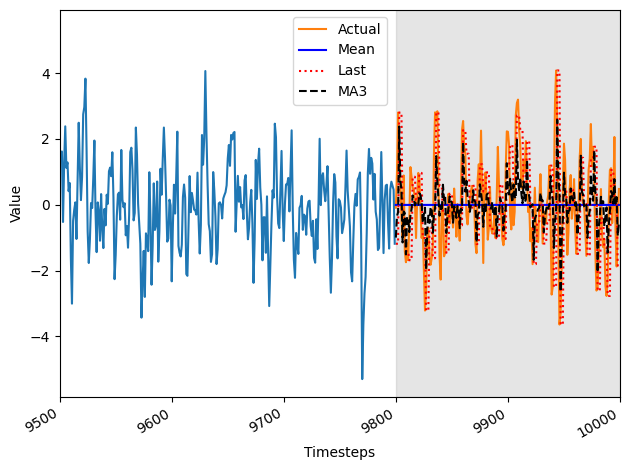

In [ ]:
fig, ax = plt.subplots()

ax.plot(MA3_train)
ax.plot(MA3_test['value'], label='Actual')
ax.plot(MA3_test['pred_mean'], 'b-', label='Mean')
ax.plot(MA3_test['pred_last_value'], 'r:', label='Last')
ax.plot(MA3_test['pred_MA3'], 'k--', label='MA3')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

ax.axvspan(9800, 10000, color='#808080', alpha=0.2)

plt.xlim(9500, 10000)
fig.autofmt_xdate()
plt.tight_layout()

+ **8. Mida el MSE e identifique su modelo campeón.**

In [ ]:
from sklearn.metrics import mean_squared_error
mse_mean = mean_squared_error(MA3_test['value'], MA3_test['pred_mean'])
mse_last = mean_squared_error(MA3_test['value'], MA3_test['pred_last_value'])
mse_MA = mean_squared_error(MA3_test['value'], MA3_test['pred_MA3'])

print('El MSE  con los diferentes metodos ingenuos Y MA(3)')
print(f'El Error MSE con la media historica es {mse_mean}')
print(f'El Error MSE con la media con la última observación es {mse_last}')
print(f'El Error MSE con la MA(2) es {mse_MA}')

El MSE  con los diferentes metodos ingenuos Y MA(3)
El Error MSE con la media historica es 1.9248140859815992
El Error MSE con la media con la última observación es 3.1865529484710264
El Error MSE con la MA(2) es 1.5065280391200084


+ **9. Dibuje sus MSE en un gráfico de barras.**

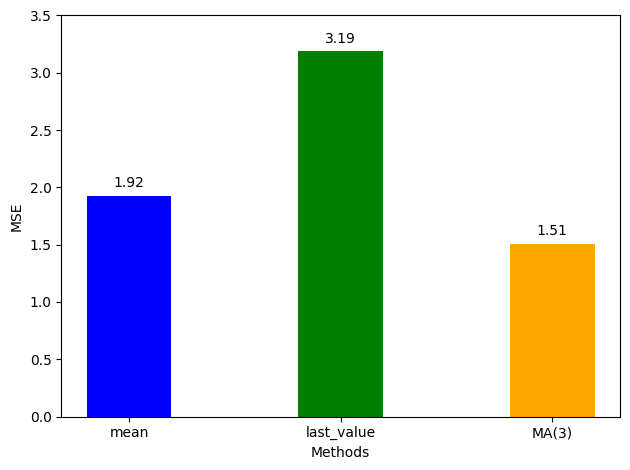

In [ ]:
import matplotlib.pyplot as plt

# Datos
x = ['mean', 'last_value', 'MA(3)']
y = [mse_mean, mse_last, mse_MA]

# Colores para las barras (puedes modificar esta lista según tus preferencias)
colors = ['blue', 'green', 'orange']

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Graficar las barras con colores específicos
bars = ax.bar(x, y, width=0.4, color=colors)

# Etiquetas y límites del eje y
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 3.5)

# Añadir texto con los valores encima de cada barra
for bar, value in zip(bars, y):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.05,
             round(value, 2),
             ha='center', va='bottom')

# Ajustar el diseño y guardar la figura
plt.tight_layout()
plt.savefig('figures.png', dpi=300)
plt.show()


# **Resumen - Capítulo 4**
+ *Un proceso de media móvil establece que el valor presente depende linealmente de la media, el término de error presente y los términos de error pasado.*
+ *Los términos de error se distribuyen normalmente.*
+ *Puede identificar el orden $q$ de un proceso de media móvil estacionaria estudiando el gráfico ACF*.
+ *Los coeficientes son significativos sólo hasta el rezago q*.
+ *Puede predecir hasta $q$ pasos hacia el futuro porque los términos de error no se observan en los datos y deben estimarse de forma recursiva*.
+ *Predecir más allá de $q$ pasos hacia el futuro simplemente devolverá la media de la serie*.
+ *Para evitarlo, puede aplicar pronósticos continuos.*
+ *Si aplica una transformación a los datos, debe deshacerla para que sus predicciones vuelvan a la escala original de los datos.*
+ *El modelo de media móvil supone que los datos son estacionarios.*
+ *Por lo tanto, sólo puedes utilizar este modelo en modo estacionario*.